# Area for testing Code

### Try code loading weather from weather station
This is updated code from a custom scraper

In [1]:
import requests
import csv
import lxml.html as lh
import datetime
from datetime import date

from util.UnitConverter import ConvertToSystem
from util.Parser import Parser
from util.Utils import Utils
import pandas as pd
from load_data import WeatherData2

import matplotlib.pyplot as plt
import datetime
from visualize_data import Analyze_WD
from load_data import SummaryData, WeatherData2

In [2]:
def scrap_station(weather_station_url="https://www.wunderground.com/dashboard/pws/IDRSING3", 
                  unit_system="metric", start_DATE="", end_DATE="", timeout = 5, savepath="", output=True):
    """Get data from Weather Station. 
    Input: Parameters about station and start and end date
    Return: Pandas Dataframe in format for Weather Station"""
    
    session = requests.Session()
    
    url_gen = Utils.date_url_generator(weather_station_url, start_DATE, end_DATE)
    station_name = weather_station_url.split('/')[-1]
    if len(savepath)==0:
        savepath = f'{station_name}.csv'

    with open(savepath, 'a+', newline='') as csvfile:
        dfs = [] # Where the output will be saved to
        for date_string, url in url_gen:
            try:
                if output:
                    print(f'Downloading Weather data from {url}')
                history_table = False
                while not history_table:
                    html_string = session.get(url, timeout=timeout)
                    doc = lh.fromstring(html_string.content)
                    history_table = doc.xpath('//*[@id="main-page-content"]/div/div/div/lib-history/div[2]/lib-history-table/div/div/div/table/tbody')
                    if not history_table:
                        if output:
                            print("Refreshing session.")
                        session = requests.Session()

                data_rows = Parser.parse_html_table(date_string, history_table)

                converter = ConvertToSystem(unit_system)
                data_to_write = converter.clean_and_convert(data_rows)
                dfs.append(pd.DataFrame(data_to_write))
                    
                print(f'Saving {len(data_to_write)} rows')
            except Exception as e:
                print(e)
        df=pd.concat(dfs)
        df["station"] = station_name
        return df
    
def to_normed_df(df):
    """Transform a scrapped wunderground dataframe to a normalized df"""  
    
    dct = {'Temperature': 'temp', 'Precip_Accum': 'total_rain', 'Precip_Rate': 'hour_rain',  'Humidity': 'humidity',
           'Wind': 'wind_direction',  'Speed': 'wind',  'Speed': 'wind',  'Gust': 'wind_gust',
            'Pressure': 'pressure',  'Solar': 'solar', 'Dew_Point': 'dewpoint'
           }
    df_new = df.rename(columns=dct)
    
    ### Update data column as combo of date and time
    df_new["date"] 	=  pd.to_datetime(df["Date"].str.replace("/","-") + " " +  df["Time"])
    return df_new

def check_valid_wunder_df(df):
    """Does a quick check whether dataframe is valid for 
    software here."""
    
    cols = ['temp', 'hour_rain', 'total_rain', 'date', 'humidity',
       'wind_direction', 'wind', 'wind_gust', 'pressure', 'solar', 'dewpoint',
       'station']
    columns = df.columns
    
    for c in cols:
        if c not in columns:
            raise RuntimeWarning(f"Column {c} is missing")

In [ ]:
%%time
### Test running the scrapper

d1 = date(2017, 7, 1)
d2 = date(2017, 7, 3)

df = scrap_station(start_DATE=d1, end_DATE=d2)

In [46]:
dft = to_normed_df(df)

In [47]:
check_valid_wunder_df(dft)

In [57]:
d1 = date(2017, 7, 31)
d1 + datetime.timedelta(days=1)

datetime.date(2017, 8, 1)

In [ ]:
date = datetime.date(df["Date"])
time = datetime.time(df["Time"])
combined = datetime.datetime.combine(date, time)

In [65]:
df.head(2)

,Date,Time,Temperature,Dew_Point,Humidity,Wind,Speed,Gust,Pressure,Precip_Rate,Precip_Accum,UV,Solar,station
0,2017/07/01,02:03 AM,17.28,12.78,75.0,West,0.00,0.00,1008.81,0.0,0.0,0.0,0.0,IDRSING3
1,2017/07/01,02:08 AM,17.50,12.39,72.0,West,2.57,3.54,1009.14,0.0,0.0,0.0,0.0,IDRSING3


In [66]:
to_normed_df(df).head(2)

,Date,Time,temp,dewpoint,humidity,wind_direction,wind,wind_gust,pressure,hour_rain,total_rain,UV,solar,station
0,2017/07/01,02:03 AM,17.28,12.78,75.0,West,0.00,0.00,1008.81,0.0,0.0,0.0,0.0,IDRSING3
1,2017/07/01,02:08 AM,17.50,12.39,72.0,West,2.57,3.54,1009.14,0.0,0.0,0.0,0.0,IDRSING3


In [59]:
df.columns.values

array(['Date', 'Time', 'Temperature', 'Dew_Point', 'Humidity', 'Wind',
       'Speed', 'Gust', 'Pressure', 'Precip_Rate', 'Precip_Accum', 'UV',
       'Solar'], dtype=object)

## Test Loading the Data

In [7]:
df = pd.read_csv("IDRSING3.csv")

In [3]:
df1 = pd.read_csv("./Data/2017/10.csv")

# Test Production Code

In [3]:
wd = WeatherData2()
wd.output = True

df = wd.download_data_day(4, 5, 2022)

Downloading: Year: 2022 Month: 5 Day: 4 
list index out of range! probably caused by an empty row in the data
Saving 286 rows


### Test Loading of whole Month

In [ ]:
%%time

month = datetime.date(year=2022, month=7, day=3)
# Test the Class:
wd = WeatherData2()
wd.local_save_month(month)

NameError: name 'datetime' is not defined

### Test plotting of clean data

In [5]:
%%time

# Test the Class:
wd = WeatherData2()
wd.output = True

CPU times: user 70 μs, sys: 0 ns, total: 70 μs
Wall time: 95.6 μs


### Load the data

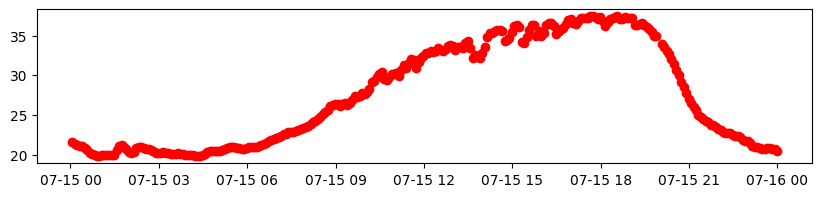

In [8]:
date = datetime.date(year=2024, month=7, day=15)

df = wd.give_data_day_clean(date)

plt.figure(figsize=(10,2))
plt.plot(df.index, df["temp"], 'ro')
plt.show()

#df.head(10)

Loading Rain from: 2024-05-01
Max Rain: 0.00
Loading Rain from: 2024-05-02
Max Rain: 0.00
Loading Rain from: 2024-05-03
Max Rain: 5.84
Loading Rain from: 2024-05-04
Max Rain: 0.00
Loading Rain from: 2024-05-05
Max Rain: 0.00
Loading Rain from: 2024-05-06
Max Rain: 0.00
Loading Rain from: 2024-05-07
Max Rain: 5.84
Loading Rain from: 2024-05-08
Max Rain: 5.84
Loading Rain from: 2024-05-09
Max Rain: 0.00
Loading Rain from: 2024-05-10
Max Rain: 0.00
Loading Rain from: 2024-05-11
Max Rain: 0.00
Loading Rain from: 2024-05-12
Max Rain: 0.00
Loading Rain from: 2024-05-13
Max Rain: 0.00
Loading Rain from: 2024-05-14
Max Rain: 0.00
Loading Rain from: 2024-05-15
Max Rain: 0.00
Loading Rain from: 2024-05-16
Max Rain: 1.27
Loading Rain from: 2024-05-17
Max Rain: 6.60
Loading Rain from: 2024-05-18
Max Rain: 0.00
Loading Rain from: 2024-05-19
Max Rain: 0.00
Loading Rain from: 2024-05-20
Max Rain: 4.32
Loading Rain from: 2024-05-21
Max Rain: 9.14
Loading Rain from: 2024-05-22
Max Rain: 0.25
Loading Ra

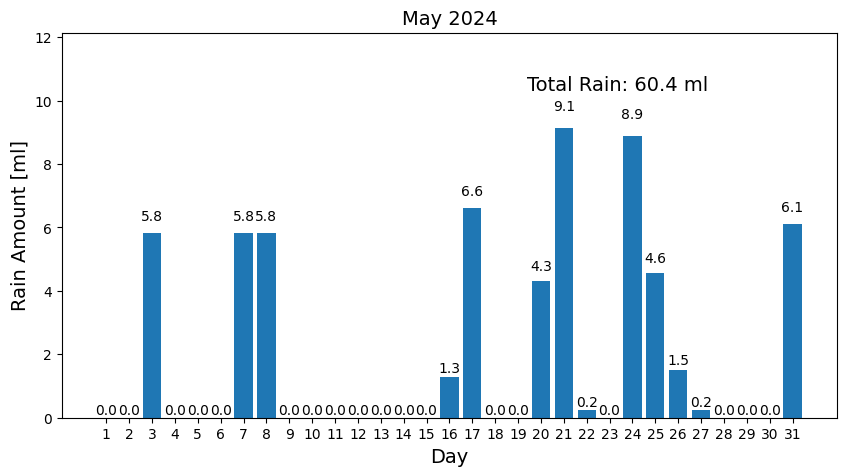

Done!!


In [9]:
sd = SummaryData(wd)
v_wd = Analyze_WD(wd, sd)

month = datetime.date(year=2024, month=5, day=1)
v_wd.visualize_rain_month(date_month=month)

# Calculate and save Summary Stats manually
Do here for whole of 2020

In [ ]:
%%time
d1 = datetime.date(2020, 1, 1)
d2 = datetime.date(2020, 12, 31)
sd.set_summary_statistics(d1, d2)

# Test getting summary data

In [16]:
wd = WeatherData2()
wd.output = True

sd = SummaryData(wd)
v_wd = Analyze_WD(wd, sd)

month = datetime.date(year=2020, month=6, day=1)
#v_wd.visualize_rain_month(date_month=month)

### Test getting period data

In [26]:
start_date  = datetime.date(year=2020, month=2, day=1)
end_date  = datetime.date(year=2020, month=6, day=5)


df = sd.give_summary_statistics(start_date, end_date)
df

,MinT,MaxT,MeanT,TotR,TotS
2020-02-01,1.94,16.39,9.105000,0.51,1.254150
2020-02-02,4.83,13.22,9.899624,1.52,0.843513
2020-02-03,7.00,12.17,8.320854,6.86,0.527267
2020-02-04,2.50,9.72,5.370418,6.86,0.632000
2020-02-05,-0.22,4.83,2.696979,0.00,1.010408
...,...,...,...,...,...
2020-06-01,8.22,23.78,16.383826,0.00,7.054508
2020-06-02,5.44,22.06,15.039321,3.81,6.974854
2020-06-03,10.00,26.11,17.051707,0.00,7.841808
2020-06-04,7.33,26.61,18.093902,0.00,6.790875


In [27]:
sd.get_mean_month(2020)

2020-01-31    -0.470377
2020-02-29     5.671322
2020-03-31     6.287161
2020-04-30    10.751573
2020-05-31    13.313322
2020-06-30    18.415246
2020-07-31    20.282406
2020-08-31    21.602537
2020-09-30          NaN
2020-10-31          NaN
2020-11-30          NaN
2020-12-31          NaN
Freq: ME, Name: MeanT, dtype: float64

### Test getting monthly data

In [10]:
wd = WeatherData2()
month = datetime.date(year=2022, month=5, day=1)
df = wd.give_data_month(month)

In [ ]:
df

In [17]:
#df.tz_localize('CET')
#df.tz_localize("Europe/Vienna")

In [ ]:
#.tz_convert(timezone = "Europe/Vienna") 

In [2]:
from dateutil.rrule import rrule, MONTHLY

In [28]:
d1 = date(2017, 7, 31)
d2 = date(2018, 12, 3)

In [29]:
for dt in rrule(MONTHLY, dtstart=d1, until=d2):
    print(dt)

2017-07-31 00:00:00
2017-08-31 00:00:00
2017-10-31 00:00:00
2017-12-31 00:00:00
2018-01-31 00:00:00
2018-03-31 00:00:00
2018-05-31 00:00:00
2018-07-31 00:00:00
2018-08-31 00:00:00
2018-10-31 00:00:00


# Legacy

In [ ]:
def scrap_station(weather_station_url="https://www.wunderground.com/dashboard/pws/IDRSING3", 
                  unit_system="metric", start_DATE="", end_DATE="", timeout = 5, savepath="", output=True):
    """Get data from Weather Station. 
    Input: Parameters about station and start and end date
    Return: Pandas Dataframe in format for Weather Station"""
    
    session = requests.Session()
    
    url_gen = Utils.date_url_generator(weather_station_url, start_DATE, end_DATE)
    station_name = weather_station_url.split('/')[-1]
    if len(savepath)==0:
        savepath = f'{station_name}.csv'

    with open(savepath, 'a+', newline='') as csvfile:
        #fieldnames = ['Date', 'Time',	'Temperature',	'Dew_Point', 'Humidity', 'Wind', 'Speed',
        #              'Gust',	'Pressure',	'Precip_Rate',	'Precip_Accum',	'UV',   'Solar']
        #writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the correct headers to the CSV file
        # 12:04 AM	24.4 C	18.3 C	69 %	SW	0.0 km/h	0.0 km/h	1,013.88 hPa	0.00 mm	0.00 mm	0	0 w/m²
        
        #writer.writerow({'Date': 'Date', 'Time': 'Time', 
        #                 'Temperature': 'Temperature_C', 'Dew_Point':
        #                 'Dew_Point_C',	'Humidity': 'Humidity_%', 
        #                 'Wind': 'Wind', 'Speed': 'Speed_kmh',	
        #                 'Gust': 'Gust_kmh',	'Pressure': 'Pressure_hPa',	
        #                 'Precip_Rate': 'Precip_Rate_mm',	
        #                 'Precip_Accum': 'Precip_Accum_mm',	'UV': 'UV',   'Solar': 'Solar_w/m2'})
        
        dfs = [] # Where the output will be saved to
        for date_string, url in url_gen:
            try:
                if output:
                    print(f'Downloading Weather data from {url}')
                history_table = False
                while not history_table:
                    html_string = session.get(url, timeout=timeout)
                    doc = lh.fromstring(html_string.content)
                    history_table = doc.xpath('//*[@id="main-page-content"]/div/div/div/lib-history/div[2]/lib-history-table/div/div/div/table/tbody')
                    if not history_table:
                        if output:
                            print("Refreshing session.")
                        session = requests.Session()

                # parse html table rows
                data_rows = Parser.parse_html_table(date_string, history_table)

                # convert to metric system
                converter = ConvertToSystem(unit_system)
                data_to_write = converter.clean_and_convert(data_rows)
                dfs.append(pd.DataFrame(data_to_write))
                    
                print(f'Saving {len(data_to_write)} rows')
                #writer.writerows(data_to_write)
            except Exception as e:
                print(e)
        df=pd.concat(dfs)       
        return df